In [2]:
import sys 
sys.path.append('../')

from src.data.exact.core import Core

core = Core.sample_core()

/home/mharmanani/TRUSnet/src/data/exact/core.py:228: UserWarning: You appear to be calling Core constructor manually. It is preferable to call `Core.create_core(specifier)`
                    which will cache core instances and not double memory requirements for core objects!
                
  warn(


In [3]:
core.metadata

{'patient_id': 28,
 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/Benign/UVA-0028_LBL_Benign.mat',
 'center': 'UVA',
 'loc': 'LBL',
 'grade': 'Benign',
 'age': 52,
 'family_history': False,
 'psa': 5.71,
 'pct_cancer': nan,
 'primary_grade': nan,
 'secondary_grade': nan,
 'patient_specifier': 'UVA-0028',
 'core_specifier': 'UVA-0028_LBL'}

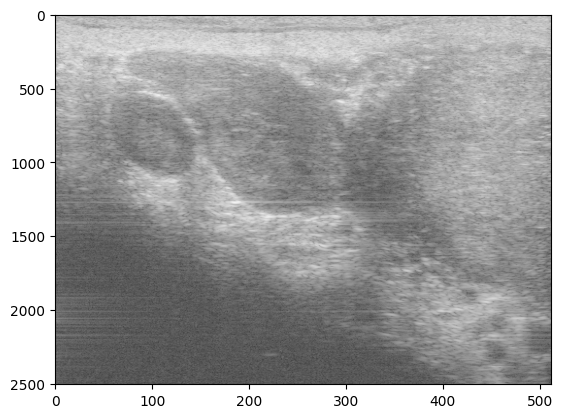

In [5]:
core.bmode
import matplotlib.pyplot as plt 
plt.imshow(core.bmode, aspect='auto', cmap='gray')

In [7]:
core.rf.shape

(2504, 512)

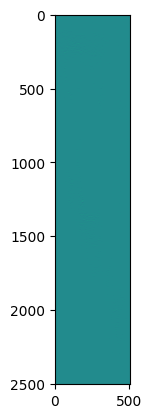

In [8]:
plt.imshow(core.rf)

In [10]:
grid = core.get_grid_view((1, 1))

In [11]:
grid.shape

(28, 46)

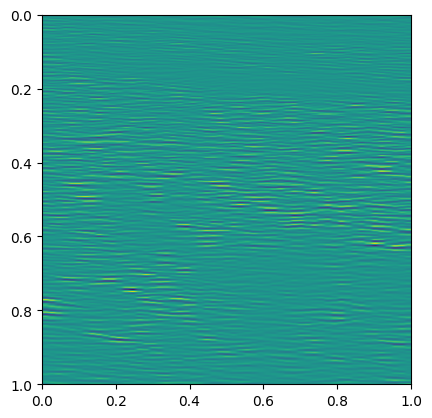

In [15]:
plt.imshow(grid[0:5, 0:5], extent=[0, 1, 1, 0])

In [46]:
from src.data.exact.core import PatchViewConfig
cfg = PatchViewConfig(
    prostate_region_only=False,
    return_extras=("positions", "mask_intersections")
)
pv = core.get_patch_view_from_config(
    cfg
)

In [47]:
pv[0][0].shape

(445, 55)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

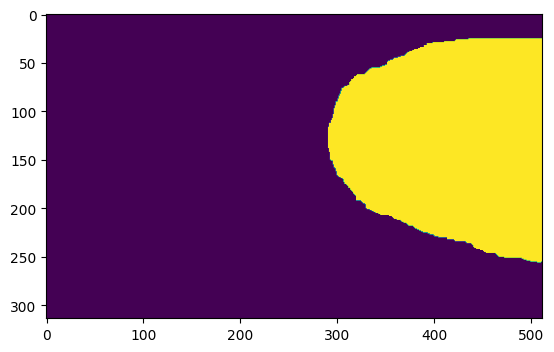

In [48]:
plt.imshow(core.prostate_mask)
core.prostate_mask

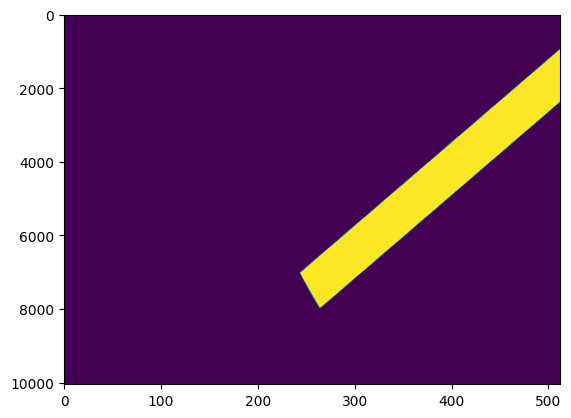

In [49]:
plt.imshow(core.needle_mask, aspect='auto')

In [50]:
from src.data.exact.resources import metadata
table = metadata()

In [51]:
table

,patient_id,path_on_server,center,loc,grade,age,family_history,psa,pct_cancer,primary_grade,secondary_grade,patient_specifier,core_specifier
0,4,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LML,Benign,54,False,7.0,NaN,NaN,NaN,CRCEO-0004,CRCEO-0004_LML
1,4,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,RBL,Benign,54,False,7.0,NaN,NaN,NaN,CRCEO-0004,CRCEO-0004_RBL
2,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LML,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_LML
3,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LMM,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_LMM
4,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,RBL,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_RBL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,628,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RAM,GS10,76,False,1.2,100.0,5.0,5.0,UVA-0628,UVA-0628_RAM
6603,628,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RBL,GS10,76,False,1.2,100.0,5.0,5.0,UVA-0628,UVA-0628_RBL
6604,628,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RBM,GS10,76,False,1.2,100.0,5.0,5.0,UVA-0628,UVA-0628_RBM
6605,628,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RML,GS10,76,False,1.2,100.0,5.0,5.0,UVA-0628,UVA-0628_RML


In [52]:
from src.data.exact.transforms import TransformConfig, TransformV3, Normalize, TensorImageAugmentation, UltrasoundArrayAugmentation
transform = TransformV3(
)

model_in = transform(pv[0][0])

In [53]:
from src.modeling.registry import create_model
model = create_model(
    'resnet10_feature_extractor'
)

model(model_in.unsqueeze(0)).shape

torch.Size([1, 512])

In [64]:
from src.data.exact.dataset.rf_datasets import PatchesDatasetNew
import torch
ds = PatchesDatasetNew(
    root=None, 
    core_specifier_list=list(table['core_specifier'].head(100)),
    patch_transform=transform, 
    patch_view_config=PatchViewConfig(prostate_region_only=False),
    label_transform=lambda label: torch.tensor(label).long(), 
)

Indexing Patches: 100%|██████████| 100/100 [00:00<00:00, 180.94it/s]


In [65]:
ds[0][0].shape

torch.Size([1, 256, 256])

In [66]:
from torch.utils.data import dataloader

dl = dataloader.DataLoader(ds, 16)

In [69]:
patches, positions, labels, metadata = next(iter(dl))

In [70]:
patches.shape

torch.Size([16, 1, 256, 256])

In [72]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [87]:
from src.lightning.datamodules.exact_datamodule import ExactPatchDMConfig, PatchDataModuleForSelfSupervisedLearning, LoaderConfig
from src.data.exact.splits import Splits

splits = Splits(cohort_specifier=['UVA600', 'CRCEO428'], merge_val_centers=True, merge_test_centers=True)
splits.get_val()

train_transform = TransformV3(
    norm=Normalize(), 
    tensor_transform=TensorImageAugmentation()
)
eval_transform = train_transform

dm = PatchDataModuleForSelfSupervisedLearning(splits=splits, patch_transform_eval=eval_transform, patch_transform_train=train_transform)

In [88]:
dm.setup()

Indexing Patches: 100%|██████████| 138/138 [00:00<00:00, 64284.09it/s]


In [89]:
train_loader = dm.train_dataloader()

In [104]:
batch = next(iter(train_loader))

In [105]:
(X1, X2), pos, label, metadata = batch

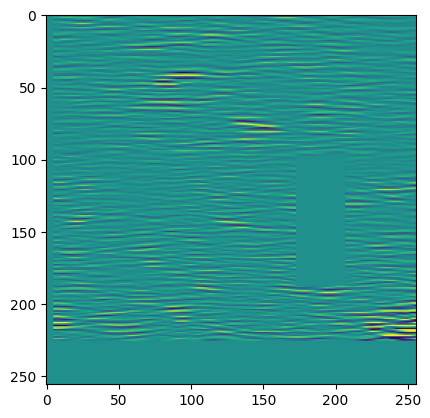

In [106]:
plt.imshow(X1[0][0])

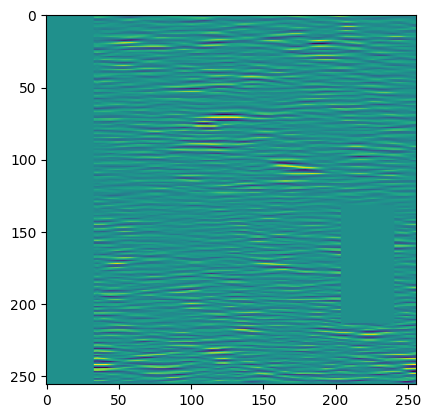

In [109]:
plt.imshow(X2[0][0])

In [77]:
dm.splits.get_train()

['UVA-0028_LBL',
 'UVA-0033_LML',
 'UVA-0053_LAL',
 'UVA-0071_LML',
 'UVA-0082_LAM',
 'UVA-0088_RBM',
 'UVA-0091_RBL',
 'UVA-0095_RAM',
 'UVA-0169_LBL',
 'UVA-0230_RBL',
 'UVA-0232_LAM',
 'UVA-0252_LBM',
 'UVA-0259_LBL',
 'UVA-0267_LAM',
 'UVA-0272_RML',
 'UVA-0284_RBM',
 'UVA-0293_RBM',
 'UVA-0293_RML',
 'UVA-0316_LAM',
 'UVA-0316_RBL',
 'UVA-0323_LAM',
 'UVA-0325_LBM',
 'UVA-0353_RAL',
 'UVA-0387_LML',
 'UVA-0387_RML',
 'UVA-0413_RBL',
 'UVA-0432_RAL',
 'UVA-0436_LBM',
 'UVA-0456_RMM',
 'UVA-0488_LBM',
 'UVA-0505_LMM',
 'UVA-0556_LBL',
 'UVA-0563_LMM',
 'UVA-0572_LBL',
 'UVA-0577_LBM',
 'UVA-0583_LMM',
 'UVA-0591_LBM',
 'UVA-0595_RAL',
 'UVA-0616_RAL',
 'UVA-0620_LAL',
 'UVA-0622_RMM',
 'UVA-0009_LBM',
 'UVA-0015_LAM',
 'UVA-0033_LBL',
 'UVA-0050_LMM',
 'UVA-0057_LML',
 'UVA-0068_LBL',
 'UVA-0068_RBL',
 'UVA-0071_RMM',
 'UVA-0074_RAL',
 'UVA-0122_RAL',
 'UVA-0138_LAL',
 'UVA-0182_LMM',
 'UVA-0220_LBM',
 'UVA-0225_LBM',
 'UVA-0234_LAM',
 'UVA-0234_LMM',
 'UVA-0272_RMM',
 'UVA-0274_RMM